In [3]:
#%matplotlib inline
%qtconsole

import os
import cPickle
import numpy as np
import pandas
from scipy import linalg

#import matplotlib
#import matplotlib.pyplot as plt
#import matplotlib.colors as colors
#from matplotlib.figure import Figure
#from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.basemap import Basemap

figdir = 'Figs/'

proxy_pandas_metafile = 'NCDC_v0.1.0all_Metadata.df.pckl'
proxy_pandas_datafile = 'NCDC_v0.1.0all_Proxies.df.pckl'

proxy_meta = pandas.read_pickle(proxy_pandas_metafile)
proxy_data = pandas.read_pickle(proxy_pandas_datafile)


In [4]:

def getSkill(data_types,proxy_data,proxy_meta,tau,calInt,valInt,doEOF):
    ''' Constructs a LIM using the equation of Penland (1996) etc. by computing two covariance matrices at lag 0 and lag tau.
    D is a 2d matrix whos rows are indexed in time and whose columns correspond to different records.
    Tau is a unit of time and should be specified in terms of the units indexing D in time (e.g., if D is yearly, a lag of two years is specified by tau = 2)
    calInt and valInt are 2-element arrays specifying beginning and end years of calibration and validation intervals'''

    ###########
    ## Setup ##
    ###########

    import os
    import cPickle
    import numpy as np
    import pandas
    from scipy import linalg

    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    from matplotlib.figure import Figure
    from matplotlib.colors import from_levels_and_colors
    from mpl_toolkits.basemap import Basemap

    # Reformat the proxy_meta to get rid of special characters
    proxy_meta.columns = [x.strip().replace(' ','_') for x in proxy_meta.columns]
    proxy_meta.columns = [x.strip().replace('(','') for x in proxy_meta.columns]
    proxy_meta.columns = [x.strip().replace(')','') for x in proxy_meta.columns]
    proxy_meta.columns = [x.strip().replace('.','') for x in proxy_meta.columns]

    # Change the metadata file so that indices are NCDC IDs (better matchup with data file)
    proxy_meta.index = proxy_meta['NCDC_ID']

    proxy_meta['Archive_type'] = proxy_meta['Archive_type'].str.replace(' ','_')

    # sort the metadata to have the same order as the data file
    proxy_meta = proxy_meta.loc[proxy_data.columns]

    #####################################
    ## Select archive types to be used ##
    #####################################
    groups = proxy_meta.groupby('Archive_type')

    # Groups can be any of the following, coded by letters as specified in this dict:
    data_dict = {'c': 'Corals_and_Sclerosponges', 
                 'i': 'Ice_Cores', 
                 'l': 'Lake_Cores',
                 'm': 'Marine_Cores',
                 's': 'Speleothems',
                 't': 'Tree_Rings'}

    tr = pandas.DataFrame()
    for x in data_types:
        test = groups.get_group(data_dict[x])
        tr = pandas.concat([tr,test])
        pmr = proxy_meta.loc[tr.index]
        pdr = proxy_data[tr.index]

    # Cut the data down to a relevant interval to speed binning
    pdr = pdr[0:2013]

    ########################################################
    ## Bin data and subselect time frames for cal and val ## 
    ########################################################

    # Bin "average" (ignoring missing values) the data with bin widths tau. 
    # In general these outputs can have many missing values.

    pd_caln = t_subsample(pdr,tau,calInt)
    pd_valn = t_subsample(pdr,tau,valInt)

    # Nmin = minimum number of averaged obs to have in a record calibration interval

    fracnnan = 0.8
    Nmin = round(fracnnan*len(pd_caln))

    # Identify proxies that have more than Nmin obs in the cal interval and more than 2 obs in the val interval (needed to make a prediction)...
    tokeep = ( (~pd_caln.isnull()).sum()>Nmin ) & ( (~pd_valn.isnull()).sum()>2 )

    # ...and eliminate the rest. Linearly interpolate to estimate missing data in cal interval
    pd_cali = pd_caln.loc[:,tokeep].interpolate()
    pd_vali = pd_valn.loc[:,tokeep].interpolate()
    pm = pmr.loc[tokeep]


    ## Normalize ##
    pd_calnm = (pd_cali - pd_cali.mean())/pd_cali.std()
    pd_valnm = (pd_vali - pd_vali.mean())/pd_vali.std()

    # One more check for any missing values in the calibration (could arise from edges of interpolation)

    #tokeep2 = ~(pd_calnm.isnull().sum()>0) & ((~pd_valnm.isnull()).sum()>0)
    tokeep2 = ~(pd_calnm.isnull().sum()>0)
    pd_cal = pd_calnm.loc[:,tokeep2]
    pd_val = pd_valnm.loc[:,tokeep2]
    pm = pm.loc[tokeep2]

    #################################################
    ## Compute a LIM over the calibration interval ##
    #################################################

    if doEOF:
        ## Convert to truncated EOF space
        [u,s,v] = np.linalg.svd(np.transpose(pd_cal.values),full_matrices=True)

        # Tolerance for SVD truncation
        #        tol = s.max()/100.
        tol = s.max()/10.
        ks = s>tol


        # in the EOF basis:
        De = np.transpose(np.dot(np.diag(s[ks]),(v[:sum(ks),:])))

    else:
        De = pd_cal.values

    l,m = De.shape
    Dt  = De.transpose()
    c0 = np.cov(Dt)
    ctfull = np.cov(Dt[:,tau:],Dt[:,:-tau])

    # relelvant portion is one of the off-diagonal covariance submatrices
    ct = ctfull[m:,:-m]
    
    Go = np.dot(ct,linalg.pinv(c0,cond=.01))
    #    G = np.dot(ct,linalg.pinv(c0))

    if doEOF:
        # Project out of SVD space into proxy space
        G = np.dot(u[:,:sum(ks)],np.dot(Go,u[:,:sum(ks)].transpose()))
    else:
        G = Go




    ##############################################################################
    ## Simulate values in the validation interval at tau leads and compute RMSE ##
    ##############################################################################
    # Maybe should not include interpolated times?

    pred = np.dot(G,pd_val.values.transpose())
    rmse = np.sqrt(np.nanmean((pd_val.values.transpose()[:,1:]-pred[:,:-1])**2,1))

    rdf = pandas.DataFrame(columns=pd_val.columns)
    rdf.loc[1] = rmse
    
    #################
    ## Make plots! ##
    #################

    # Matrices

    plt.figure(figsize=(20,10))
    ax1 = plt.subplot(1,3,1)
    #plt.matshow((c0))
    plt.imshow(c0, origin='upper',interpolation='none')
    if doEOF: 
        ttl = ax1.set_title('Lag 0 covariance in the EOF basis',size=16)
    else: 
        ttl = ax1.set_title('Lag 0 covariance',size=16)
    plt.colorbar(fraction=0.046, pad=0.04)

    ax2 = plt.subplot(1,3,2)
    plt.imshow(ct, origin='upper',interpolation='none')
    plt.colorbar(fraction=0.046, pad=0.04)
    if doEOF: 
        ttl = ax2.set_title('Lag ' + str(tau) + ' covariance in the EOF basis',size=16)
    else: 
        ttl = ax2.set_title('Lag ' + str(tau) + ' covariance',size=16)
    #ttl = ax2.set_title('Lag ' + str(tau) + ' year covariance')

    ax3=plt.subplot(1,3,3)
    plt.imshow(G, origin='upper',interpolation='none')
    plt.colorbar(fraction=0.046, pad=0.04)
    ttl = ax3.set_title('G matrix',size=16)
#    ttl.set_position([.5, 1.1])
    plt.show()

    # eigs
#    [e,ev] = linalg.eig(Go)
#    ax3=plt.subplot(1,2,2)
#    ax3=plt.subplot(1,2,1)
#    plt.plot(np.real(np.log(e)))
#    plt.title('Real part of log eigenvalues of G')

#    ax3=plt.subplot(1,2,2)
#    plt.plot(np.imag(np.log(e)))
#    plt.title('Imaginary part of log eigenvalues of G')
#    plt.show()

    # RMSE map

    plt.figure(figsize=(20,10))
    m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
                llcrnrlon=0,urcrnrlon=360,resolution='c');
    # draw parallels and meridians.
    parallels = np.arange(-90.,90.,30.)
    # Label the meridians and parallels
    m.drawparallels(parallels,labels=[False,True,True,False])
    # Draw Meridians and Labels
    meridians = np.arange(-180.,181.,30.)
    m.drawmeridians(meridians)
    m.drawmapboundary(fill_color='white')

    mkr_dict = {'Corals_and_Sclerosponges': '^', 'Ice_Cores': '+', 'Lake_Cores': 'o','Marine_Cores':'d','Speleothems':'s','Tree_Rings':'x'}

    groups = pm.groupby('Archive_type')
    for name, group in groups:
        x,y = m(group.Lon_E.values,group.Lat_N.values)
        rg = rdf[group.index]
        sc = plt.scatter(x, y, c=rg, marker = mkr_dict[name], s=100, label=name.replace('_',' '),edgecolors='none')

    plt.legend(loc='center', bbox_to_anchor=(.15, .15),fancybox=True)

    cbar = plt.colorbar(sc, fraction=0.046, pad=0.04)
    cbar.set_label('Normalized units')
    m.drawcoastlines()
    plt.title('Prediction RMSE calibrated on ' + str(calInt[0])+ ' - ' + str(calInt[1]) + ', validated on '+  str(valInt[0])+ ' - ' + str(valInt[1]) + ', tau = ' + str(tau) + ' year',size=20,usetex=True)
    plt.show();

    # Histograms of skill
    ii = 0
    Ng = len(groups)
    plt.figure(figsize=(12,3*np.ceil(Ng/3.)))
    for name, group in groups:
        ii+=1
        plt.subplot(np.ceil(Ng/3.),3,ii)
        plt.hist(rdf[group.index].values.transpose(),bins=10)
        plt.title(name)
        plt.ylabel('Number of records')
        plt.suptitle('Histograms of RMSE',size=16)

    # Raw time series

    plt.figure(figsize=(12,20))
    ax1 = plt.subplot(1,2,1)
    lpn,mpn=pd_cal.shape
    # spacing between time series
    spc = 3;
    pns = pd_cal+np.outer(np.ones(lpn)*spc,np.arange(1,mpn+1));
    plt.plot(pns.iloc[:,:100],color='k');
    plt.autoscale(enable=True, axis='both', tight=True)
    plt.title('A subset of records used over the calibration interval')
    plt.xlabel('Time (years)')

    ax2 = plt.subplot(1,2,2)
    lpn,mpn=pd_val.shape
    # spacing between time series
    spc = 3;
    pns = pd_val+np.outer(np.ones(lpn)*spc,np.arange(1,mpn+1));
    plt.plot(pns.iloc[:,:100],color='k');
    plt.autoscale(enable=True, axis='both', tight=True)
    plt.title('A subset of records used over the valibration interval')
    plt.xlabel('Time (years)')


    ############
    ## Output ##
    ############

    return rdf,G,c0,ct,pm



In [5]:
def t_subsample(recdf,tau,intervalo):
    '''Takes an array record and bin averages it (using nanmean) into bins of length tau. If the length of rec is not an integer multiple of tau, then the interval will be truncated.

recdf: DataFrame of the form of proxy_data (columns are records, indexed by year)
tau: bin width
interval: two-element array giving the start and end years. Make sure that these are a subset of the indices of recdf; there is nothing to catch an error if this is not true and I'm not sure what will happen.
'''
    # Do nothing if tau is 1.
    if tau==1:
        return recdf[intervalo[0]:intervalo[1]]    

    # If not:

    # Compute new times.
    # Change the interval so that it's an integer multiple of tau.
    intl = int(np.diff(intervalo))
    interval = intervalo
    interval[1] = interval[0]+intl-np.mod(intl,tau)
    newt = np.arange(interval[0],interval[1],tau) + tau/2
    # define a new dataframe to populate
    df = pandas.DataFrame(index=newt)

    # Loop through different records, bin them, and populate df with binned values

    for ii in np.arange(0,len((recdf.columns))):
        #rec = recdf.iloc[interval[0]:(interval[1]-np.mod(intl,tau)),ii].values
        rec = recdf.iloc[interval[0]:interval[1],ii].values
        rr = rec.reshape(tau,-1)
        r2 = np.nanmean(rr,0)
        df[recdf.columns[ii]] = pandas.DataFrame(data=r2,index=newt)

    return df


    # pad end of record to be an integer multiple of tau
    #rec = np.concatenate([rec,np.ones(tau-np.mod(len(rec),tau))*np.nan])
    # reshape rec to facilitate averaging
    

Notes

 Groups are coded as follows:
 - 'c': 'Corals_and_Sclerosponges'
 - 'i': 'Ice_Cores'
 - 'l': 'Lake_Cores'
 - 'm': 'Marine_Cores'
 - 's': 'Speleothems'
 - 't': 'Tree_Rings'

tau is the predictive time scale. It is also the size of the bin width used to average records in time.

**Some observations**
- Just looking at different lag covariances is interesting
- If I don't condition the pseudoinverse, G gets very small




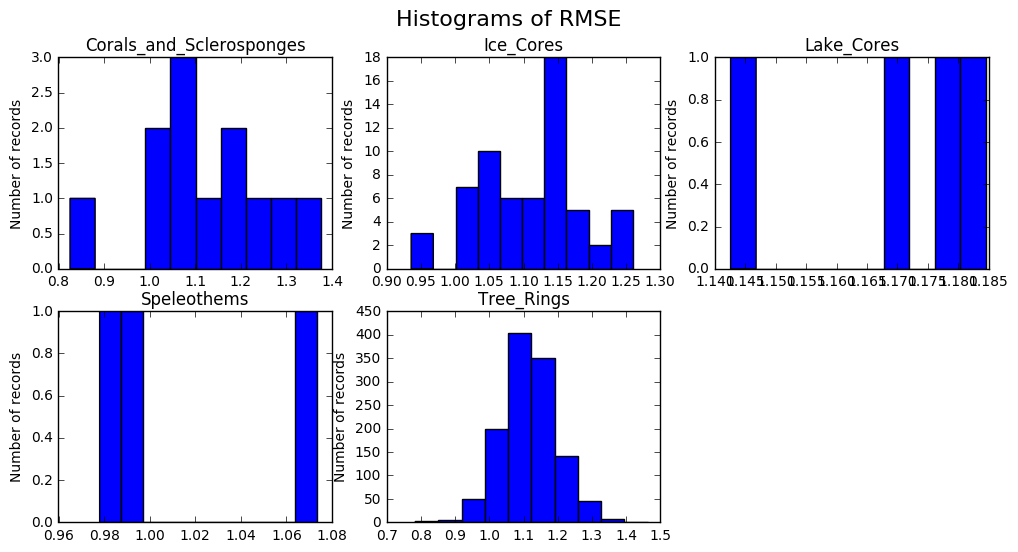

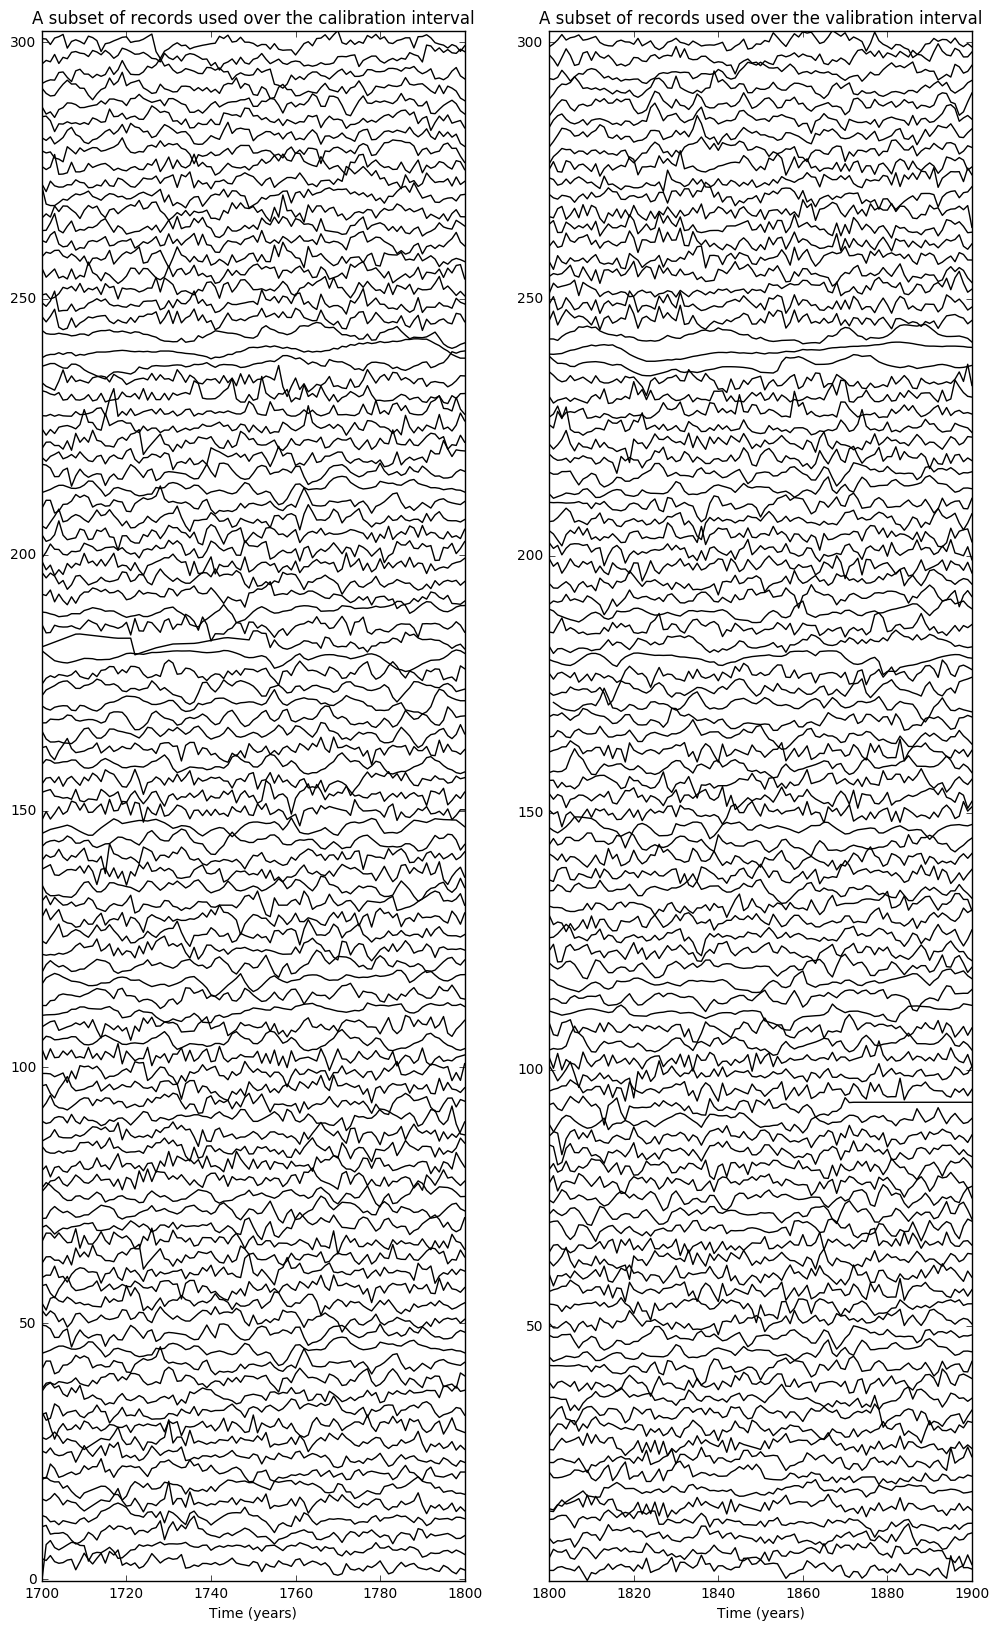

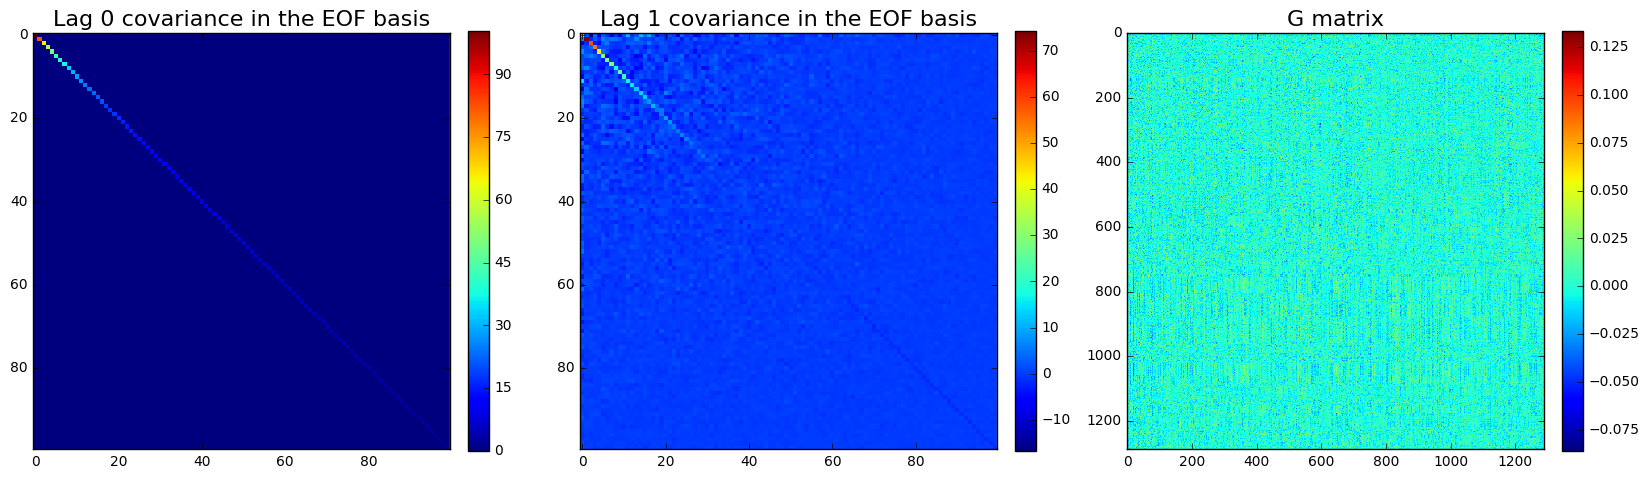

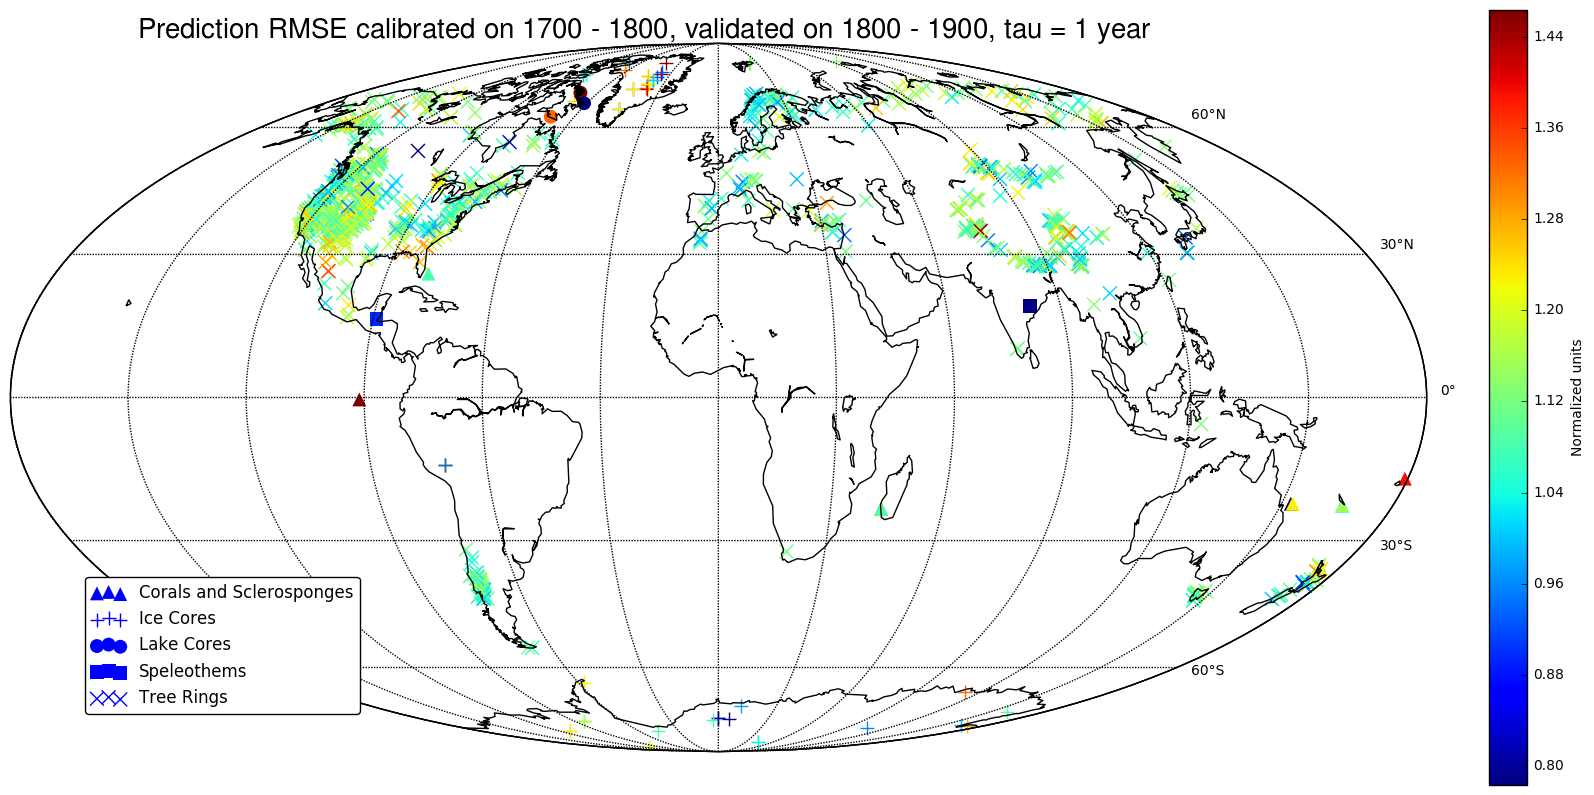

In [7]:
# Experiment 1
# 

tau = 1
calInt = [1700,1800]
valInt = [1800,1900]
#valInt = calInt

data_types = {'c', 'i','l','m','s','t'}
doEOF = True

rdf,G,c0,ct,pmSkill = getSkill(data_types,proxy_data,proxy_meta,tau,calInt,valInt,doEOF)



In [8]:
# Experiment 1.1
# EOF vs proxy basis appears to make little/no difference in the reconstruction when there is not much EOF truncation (tol = 0.1*max(lambda))

tau = 1
calInt = [1700,1800]
valInt = [1800,1900]
#valInt = calInt

data_types = {'c', 'i','l','m','s','t'}
doEOF = False

rdf,G,c0,ct,pmSkill = getSkill(data_types,proxy_data,proxy_meta,tau,calInt,valInt,doEOF)



UnboundLocalError: local variable 'G' referenced before assignment

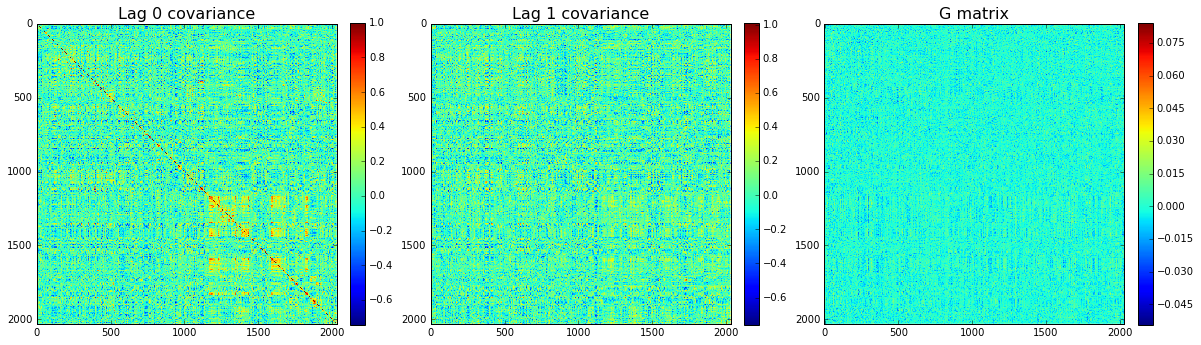

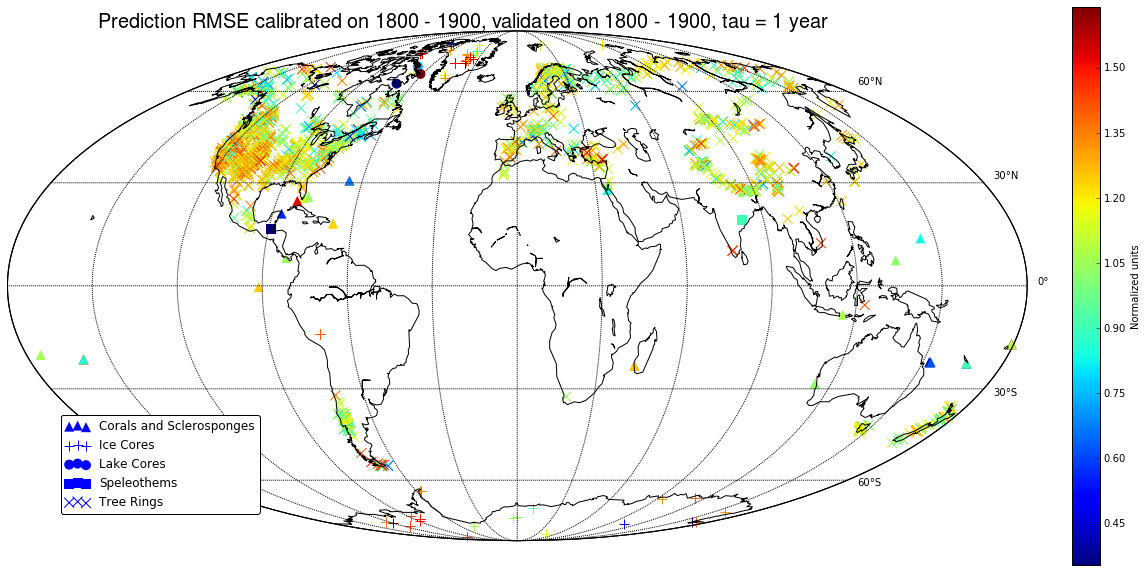

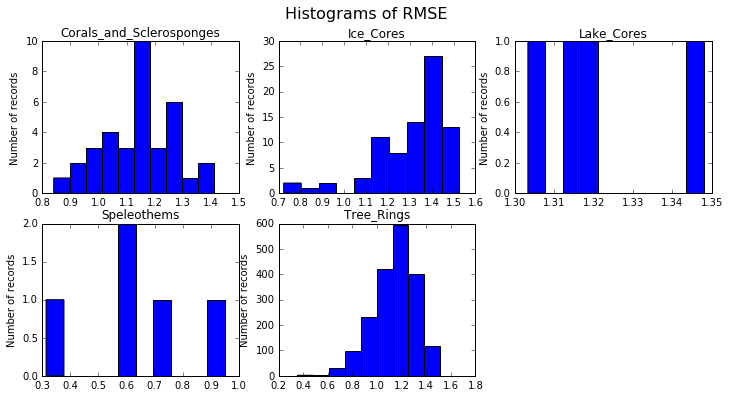

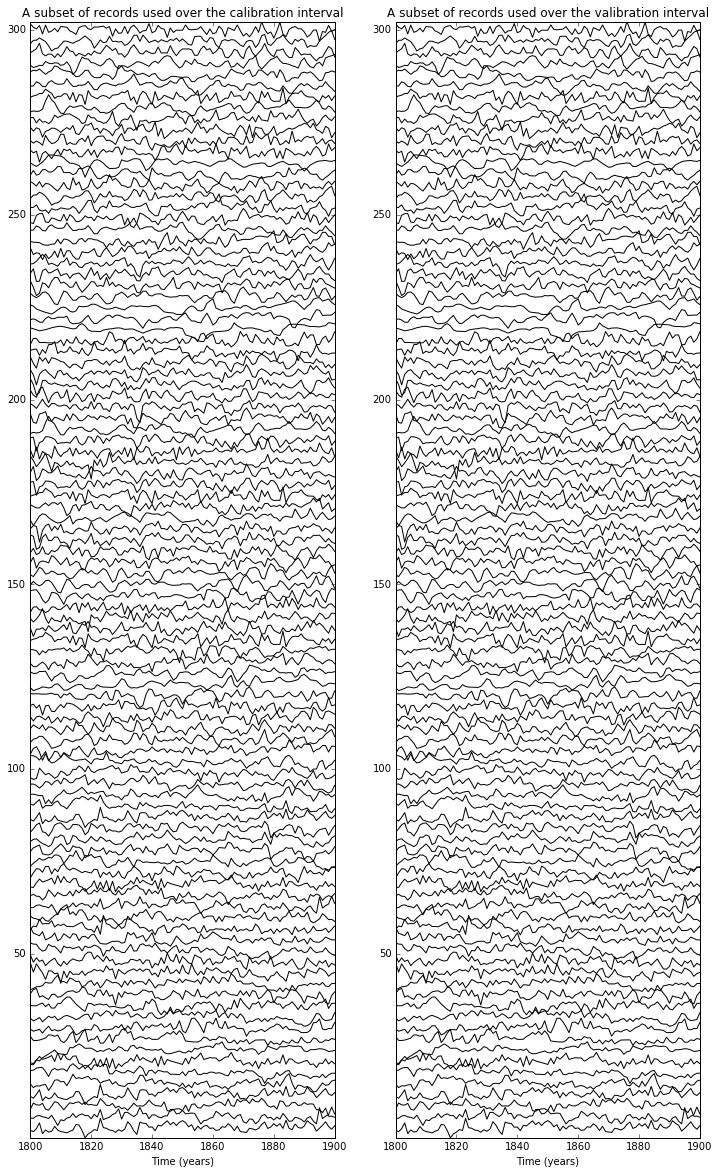

In [45]:
# Experiment 1.2
# Same cal and val. Little discernible improvement

tau = 1
calInt = [1800,1900]
valInt = [1800,1900]
#valInt = calInt

data_types = {'c', 'i','l','m','s','t'}
doEOF = False

rdf,G,c0,ct,pmSkill = getSkill(data_types,proxy_data,proxy_meta,tau,calInt,valInt,doEOF)




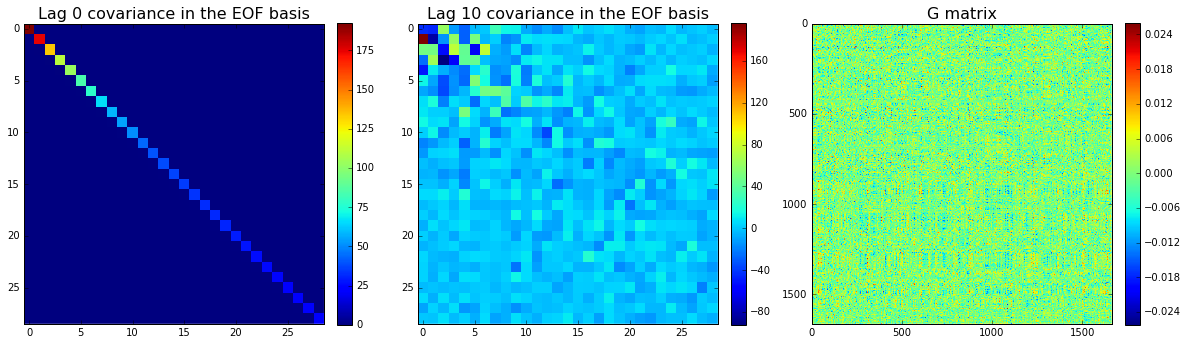

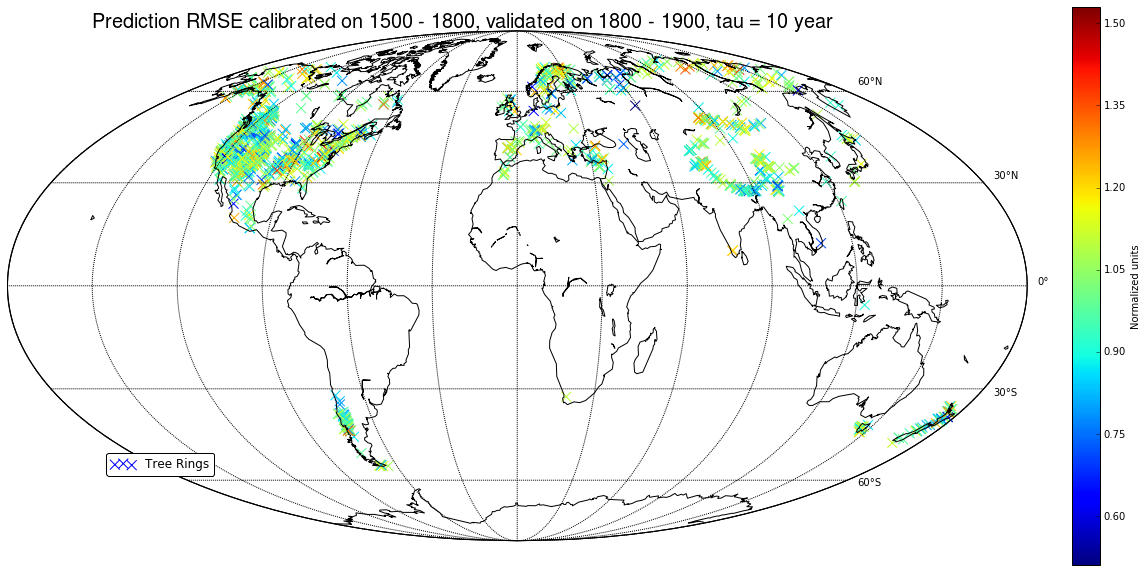

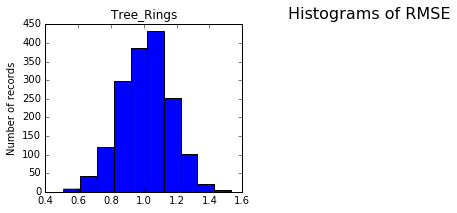

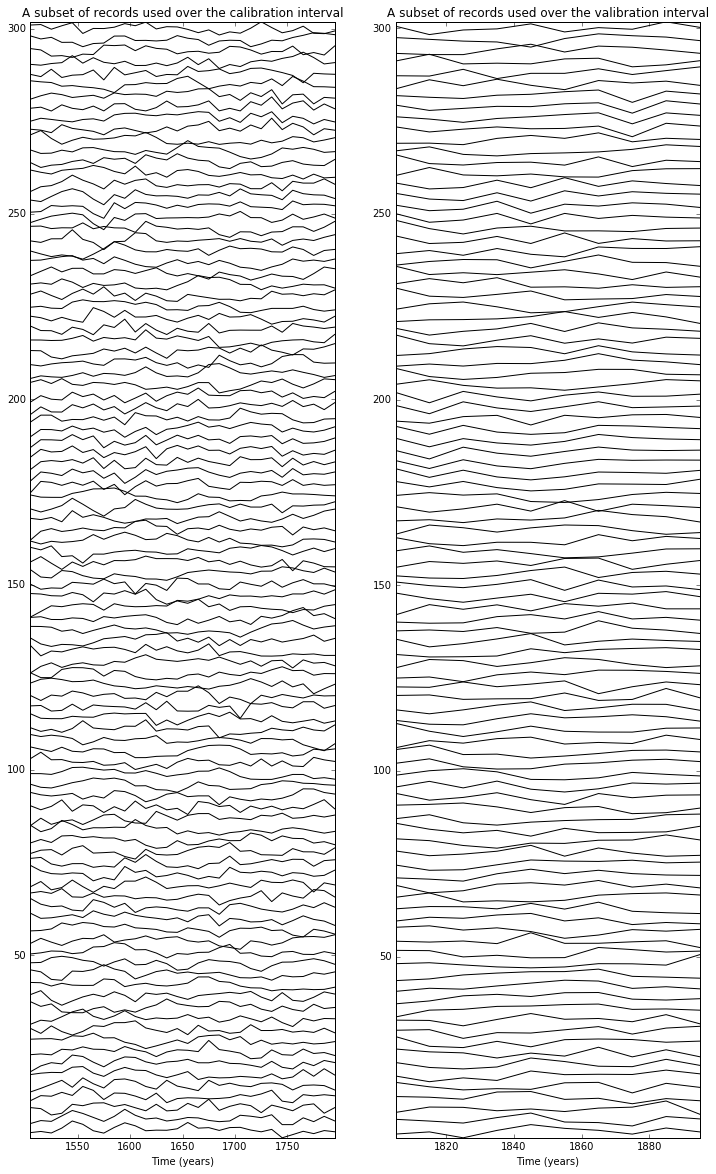

In [50]:
# Experiment 2
# Longer calibration interval, just trees

tau = 10
calInt = [1500,1800]
valInt = [1800,1900]
#valInt = calInt

data_types = {'t'}
doEOF = True

rdf,G,c0,ct,pmSkill = getSkill(data_types,proxy_data,proxy_meta,tau,calInt,valInt,doEOF)



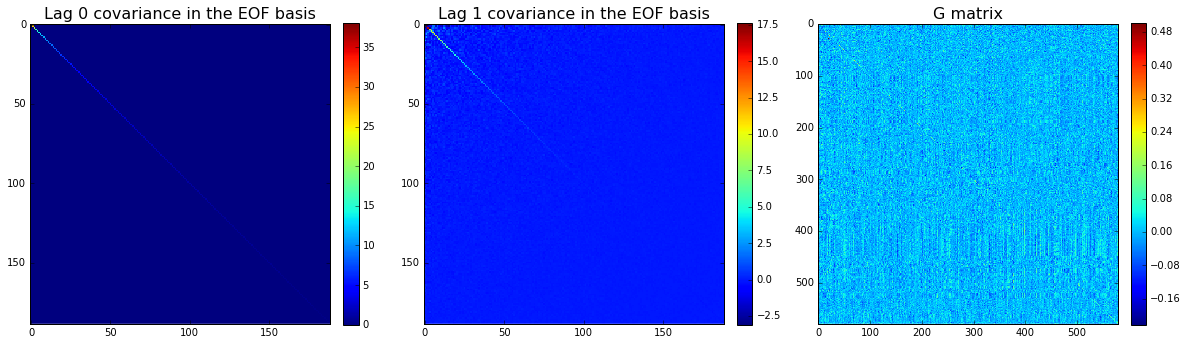

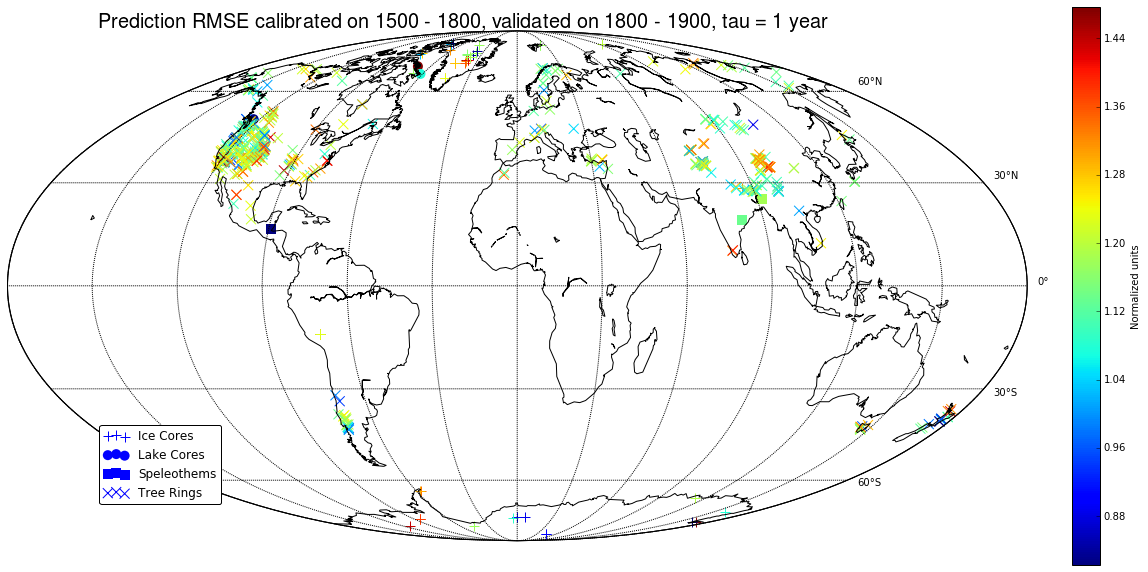

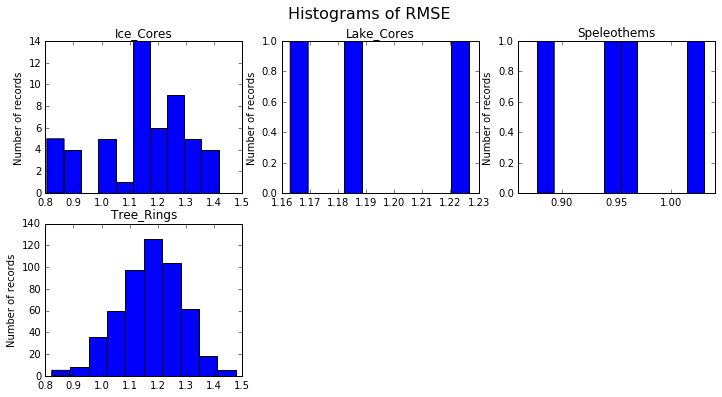

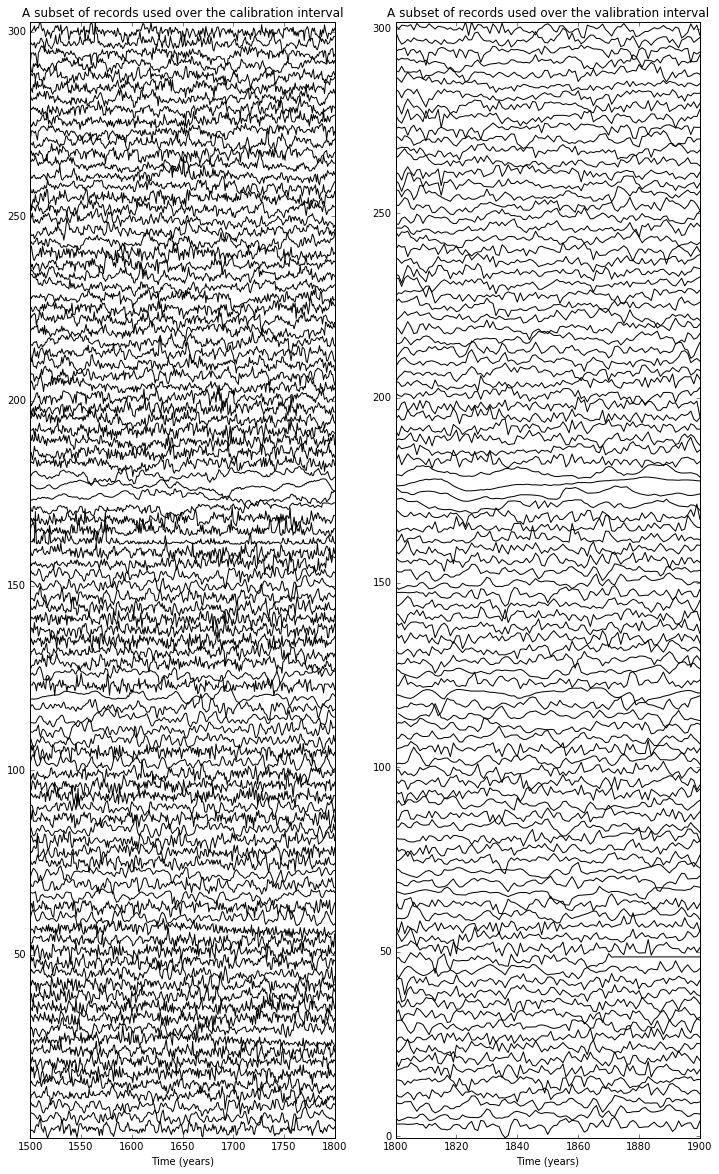

In [53]:
# Experiment 2
# Longer calibration interval, just trees

tau = 1
calInt = [1500,1800]
valInt = [1800,1900]
#valInt = calInt

data_types = {'c', 'i','l','m','s','t'}
doEOF = True

rdf,G,c0,ct,pmSkill = getSkill(data_types,proxy_data,proxy_meta,tau,calInt,valInt,doEOF)



